In [1]:
import os

In [2]:
# Remove TF warnings (this can be dangerous)
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
# See: https://gist.github.com/zrruziev/b93e1292bf2ee39284f834ec7397ee9f
# sudo echo 0 | sudo tee -a /sys/bus/pci/devices/0000\:01\:00.0/numa_node

In [4]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.utils import Sequence
from keras.layers import Conv2D, MaxPooling2D
from qkeras import *

from keras.utils import Sequence
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from qkeras import *
from qkeras.utils import _add_supported_quantized_objects

import matplotlib.pyplot as plt


import json
import random
import psutil

pi = 3.14159265359

maxval=1e9
minval=1e-9

In [5]:
# You can disable the GPU, if a GPU is present
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
from OptimizedDataGenerator import *
from loss import *

In [7]:
# Choose model type
model_type = "xysum" 

# True = use all of the time slices, False = use a subset of the timeslices
timeslices_all_enable = True

# True = load tfrecords, False = (re-)generated tfrecords
load_from_tfrecords_enabled = True

# True = load model from file, False = train it from scratch
load_model_from_hdf5_enabled = False

In [8]:
if model_type == "xysum":
    from xysum_model import *
else:
    assert False, "Selected model cannot be found"

In [9]:
# You can define a JSON configuration file locally
# {
#    "data_base_dir": "/data/dajiang/smartPixels",
#    "tfrecords_base_dir" : "/data/dajiang/smartPixels",
#    "model_base_dir": "/home/dajiang/smart-pixels-ml/weights"
# }
config_file_path = 'config.json'

# If the file does not exist, the notebook uses default values for those entries
data_base_dir = "/data/dajiang/smartPixels/dataset_2s"
tfrecords_base_dir = "/data/dajiang/smartPixels/tfrecords"
npy_base_dir = "/data/dajiang/smartPixels/npy"
model_base_dir = "/home/dajiang/smart-pixels-ml/weights"

if os.path.exists(config_file_path):
    with open(config_file_path, 'r') as file:
        data = json.load(file)
        data_base_dir = data.get('data_base_dir')
        tfrecords_base_dir = data.get('tfrecords_base_dir')
        npy_base_dir = data.get('npy_base_dir')
        model_base_dir = data.get('model_base_dir')
    print(f"Use config info from file: {data_base_dir}, {tfrecords_base_dir}, {npy_base_dir}, {model_base_dir}")
else:
    print(f"File does not exist. Use default config info: {data_base_dir}, {tfrecords_base_dir}, {npy_base_dir}, {model_base_dir}")

Use config info from file: /home/giuseppe/research/projects/smartpixels/data/dataset_2s, /home/giuseppe/research/projects/smartpixels/lindsey-smart-pixels-ml/tfrecords, /home/giuseppe/research/projects/smartpixels/lindsey-smart-pixels-ml/npy, /home/giuseppe/research/projects/smartpixels/lindsey-smart-pixels-ml/weights


In [10]:
%%time

#batch_size = 5000
#val_batch_size = 5000
batch_size = 1000
val_batch_size = 1000
train_file_size = 50
val_file_size = 10

# See: https://docs.google.com/document/d/1ZoqVyJOOAXhzt2egMWh3OoNJ6lWq5lNR6sjcYON4Vlo/edit?tab=t.0#heading=h.k6tyal7z5t5l
dataset_name = "dataset_2s"
# 50x12.5x100 micron pixel sensor => 13x21 pixel sensor array
sensor_geometry_name = "50x12P5x100"
# Either 20 or 2 timeslices
timeslices_name = "timeslices20" if timeslices_all_enable else "timeslices2"
timeslices_range = -1 if timeslices_all_enable else [0, 19]
timeslices_val = 20 if timeslices_all_enable else 2
#
batch_size_name = f"bs{batch_size}"

# Input: parquets
data_dir = f"{data_base_dir}/dataset_2s_50x12P5_parquets/unflipped/recon3D/"
labels_dir = f"{data_base_dir}/dataset_2s_50x12P5_parquets/unflipped/labels/"

# Output: tfrecords
tfrecords_dir_train = f"{tfrecords_base_dir}/tfrecords_{dataset_name}_{sensor_geometry_name}_{timeslices_name}_{batch_size_name}_train"
tfrecords_dir_val = f"{tfrecords_base_dir}/tfrecords_{dataset_name}_{sensor_geometry_name}_{timeslices_name}_{batch_size_name}_val"

training_generator = OptimizedDataGenerator(
    data_directory_path = data_dir,
    labels_directory_path = labels_dir,
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = batch_size,
    file_count = train_file_size,
    to_standardize= True,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    scaling_list = [75.0, 18.75, 10.0, 1.22],
    input_shape = (timeslices_val,13,21),
    transpose = (0,2,3,1),
    files_from_end = True,
    shuffle = True,

    load_from_tfrecords_dir = tfrecords_dir_train if load_from_tfrecords_enabled else None,
    tfrecords_dir = tfrecords_dir_train,
    use_time_stamps = timeslices_range,
    max_workers = 1, # Don't make this too large (will use up all RAM)
    seed = 10,
    quantize = True # Quantization ON
)

validation_generator = OptimizedDataGenerator(
    data_directory_path = f"{data_base_dir}/dataset_2s_50x12P5_parquets/unflipped/recon3D/",
    labels_directory_path = f"{data_base_dir}/dataset_2s_50x12P5_parquets/unflipped/labels/",
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = val_batch_size,
    file_count = val_file_size,
    to_standardize= True,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    scaling_list = [75.0, 18.75, 10.0, 1.22],
    input_shape = (timeslices_val,13,21),
    transpose = (0,2,3,1),
    files_from_end = True,
    shuffle = True,

    load_from_tfrecords_dir = tfrecords_dir_val if load_from_tfrecords_enabled else None,
    tfrecords_dir = tfrecords_dir_val,
    use_time_stamps = timeslices_range,
    max_workers = 1, # Don't make this too large (will use up all RAM)
    seed = 10,
    quantize = True # Quantization ON
)

CPU times: user 172 ms, sys: 15.4 ms, total: 188 ms
Wall time: 165 ms


In [11]:
# Create a numpy array that contains the recon3D and labels information
# X is the 20-timeslices or 2-timeslices recon3D data
# y is the labels data ['x-midplane','y-midplane','cotAlpha','cotBeta']
X_val_all = []
y_val_all = []

num_batches = validation_generator.__len__() # The total number of batches for the validation dataset
#val_num_batches = 1

for i_batch in range(num_batches): # Loop over all batches
    X_val, y_val = validation_generator.__getitem__(i_batch)
    X_val = X_val.numpy()
    y_val = y_val.numpy()
    X_val_all.append(X_val)
    y_val_all.append(y_val)

X_val_all = np.array(np.concatenate(X_val_all))
y_val_all = np.array(np.concatenate(y_val_all))

os.makedirs(npy_base_dir, exist_ok=True)
np.save(f"{npy_base_dir}/X_{timeslices_name}_val.npy", X_val_all)
np.save(f"{npy_base_dir}/y_{timeslices_name}_val.npy", y_val_all)

print(f"{npy_base_dir}/y_{timeslices_name}_val.npy")
print(X_val_all.shape)
print(y_val_all.shape)

/home/giuseppe/research/projects/smartpixels/lindsey-smart-pixels-ml/npy/y_timeslices20_val.npy
(489705, 13, 21, 20)
(489705, 4)


In [12]:
# compiles model
model = CreateModel((13,21,timeslices_val))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, 21, 20)]         0         []                            
                                                                                                  
 average_pooling2d (Average  (None, 13, 1, 20)            0         ['input_1[0][0]']             
 Pooling2D)                                                                                       
                                                                                                  
 average_pooling2d_1 (Avera  (None, 1, 21, 20)            0         ['input_1[0][0]']             
 gePooling2D)                                                                                     
                                                                                              

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_loss)

In [14]:
%%time
model_name = f"{dataset_name}_{sensor_geometry_name}_{timeslices_name}_{batch_size_name}" + (("_" if model_type != "" else "") + model_type)

best_model_hdf5 = f"{model_base_dir}/weights_7pitches/best_model_{model_name}.hdf5"
best_model_keras = f"{model_base_dir}/weights_7pitches/best_model_{model_name}.keras"
best_model_weights_hdf5 = f"{model_base_dir}/weights_7pitches/best_model_{model_name}_weights.hdf5"
best_model_weights_keras = f"{model_base_dir}/weights_7pitches/best_model_{model_name}_weights.keras"
best_model_architecture_json = f"{model_base_dir}/weights_7pitches/best_model_{model_name}_architecture.json"

print(f'Model name: {model_name}')

if not load_model_from_hdf5_enabled:
    # training
    es = EarlyStopping(
        patience=50,
        restore_best_weights=True
    )

    checkpoint_base_dir = f"{model_base_dir}/weights_7pitches/{dataset_name}_{sensor_geometry_name}_{timeslices_name}_{batch_size_name}"  + ((("_" if model_type != "" else "") + model_type)) + "-checkpoints"

    os.makedirs(checkpoint_base_dir, exist_ok=True)
    checkpoint_filepath = checkpoint_base_dir + '/weights.{epoch:02d}-t{loss:.2f}-v{val_loss:.2f}.hdf5'
    mcp = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        save_best_only=False,
    )

    class ScalePrintingCallback(keras.callbacks.Callback):    
        def on_epoch_end(self, epoch, logs=None):
            scale_layer = self.model.layers[-1]
            print(
                f"scaling layer ({epoch}):", 
                scale_layer.scale, 
                tf.math.softplus(scale_layer.scale)
            )

    print_scale = ScalePrintingCallback()
    
    history = model.fit(x=training_generator,
                        validation_data=validation_generator,
                        callbacks=[mcp],
                        epochs=5,
                        shuffle=False, # shuffling now occurs within the data-loader
                        verbose=1)

    # Revert to best model
    files = os.listdir(checkpoint_base_dir)
    vlosses = [float(f.split("-v")[1].split(".hdf5")[0]) for f in files]
    bestfile = files[np.argmin(vlosses)]
    model.load_weights(f"{checkpoint_base_dir}/{bestfile}")

    # Save (best) model information to file
    model.save(best_model_hdf5)
    model.save(best_model_keras)
    model.save_weights(best_model_weights_hdf5)
    model.save_weights(best_model_weights_keras)
    model_json = model.to_json()
    with open(best_model_architecture_json, "w") as json_file:
        json_file.write(model_json)

else:
    co = {"custom_loss": custom_loss}
    _add_supported_quantized_objects(co)
    # This overrides the previously compiled model
    # TODO: load just weights
    model = load_model(best_model_hdf5, custom_objects=co)
    model.summary()

Model name: dataset_2s_50x12P5x100_timeslices20_bs1000_xysum
Epoch 1/5
2040/2040 [==============================] - 208s 101ms/step - loss: -1784.9663 - val_loss: -4958.7104
Epoch 2/5
2040/2040 [==============================] - 199s 98ms/step - loss: -5642.2329 - val_loss: -6002.4175
Epoch 3/5
2040/2040 [==============================] - 210s 103ms/step - loss: -6305.8501 - val_loss: -6495.7456
Epoch 4/5
2040/2040 [==============================] - 203s 99ms/step - loss: -6477.2856 - val_loss: -6760.5190
Epoch 5/5
2040/2040 [==============================] - 200s 98ms/step - loss: -6866.9077 - val_loss: -6956.3154
CPU times: user 9min 11s, sys: 3min 35s, total: 12min 46s
Wall time: 17min


/home/giuseppe/ccs_venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


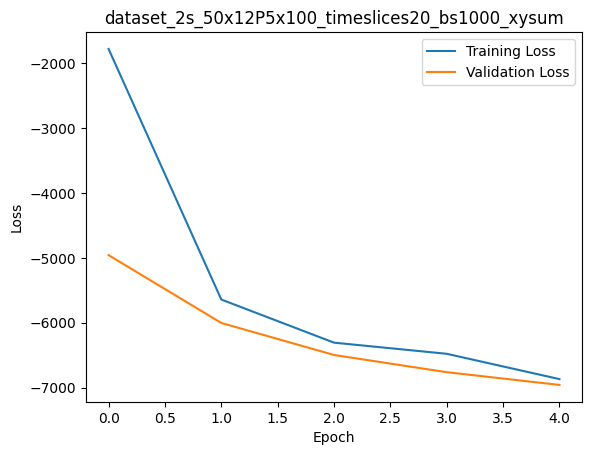

In [15]:
training_validation_loss_png = f"{model_base_dir}/weights_7pitches/training_validation_loss_{model_name}.png"
if load_model_from_hdf5_enabled:
    from PIL import Image
    import matplotlib.pyplot as plt
    img = Image.open(training_validation_loss_png)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else: 
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(model_name)
    plt.legend()
    plt.savefig(training_validation_loss_png, bbox_inches='tight', pad_inches=0.5)
    plt.show()